## Imports

In [1]:
import os
import json
import torch
import sys
import pandapower as pp
import numpy as np

import julia
julia.install()
from julia.api import Julia
jl = Julia(compiled_modules=False)

sys.path.append(os.path.abspath('../entrenamiento'))

from omegaconf import OmegaConf
from src.arquitecturas import FCNN_global, GNN_Local
from src.Data_loader import load_net, load_data

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from src.metric import NormalizedError


[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.5 LTS
  uname: Linux 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4600 MHz      98540 s         22 s      13203 s   31136408 s          0 s
  Memory: 62.63290023803711 GB (50192.87890625 MB free)
  Uptime: 195327.17 sec
  Load Avg:  0.17  0.58  0.57
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/nacho
  PATH = /home/nacho/miniconda3/envs/proy/bin:/home/nacho/.vscode-server/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/home/nacho/.local/bin:/home/nacho/miniconda3/envs/proy/bin:/home/nacho/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/

[ Info: Julia executable: /home/nacho/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /home/nacho/miniconda3/envs/proy/bin/python
│ Julia executable:
│     /home/nacho/julia-1.8.1/bin/julia
└ @ Main ~/miniconda3/envs/proy/lib/python3.12/site-packages/julia/install.jl:90
[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.5 LTS
  uname: Linux 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4554 MHz      98715 s         22 s      13246 s   31138443 s          0 s
  Memory: 62.63290023803711 GB (49773.5 MB free)
  Uptime: 195341.26 sec
  Load Avg:  0.36  0.6  0.58
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/nacho
  PATH = /home/nacho/miniconda3/envs/proy/bin:/home/nacho/.vscode-server/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/home/nacho/.local/bin:/home/nacho/miniconda3/envs/proy/bin:/home/nacho/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin

[ Info: Julia executable: /home/nacho/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /home/nacho/miniconda3/envs/proy/bin/python
│ Julia executable:
│     /home/nacho/julia-1.8.1/bin/julia
└ @ Main ~/miniconda3/envs/proy/lib/python3.12/site-packages/julia/install.jl:90


## Levantar Mejor Red

In [39]:
red = "30" # "118" o "30"
arq = "FCNN_global" # "GNN_local" o "FCNN_global"

# Levantar config y pesos del modelo
entrenamiento = "best"
cfg = OmegaConf.load(f"./runs/{red}/{arq}/" + entrenamiento + "/config.yaml")
weights_dir = f"./runs/{red}/{arq}/" + entrenamiento +  "/weights/best_model.pt"


# Settear device
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Levantar la red
num_nodes, num_gens, edge_index, edge_weights, feature_mask, net= load_net(cfg.data.red,device)

if red == "30":
    net.line["max_loading_percent"] *= 1.1
    net.ext_grid["min_q_mvar"] = -50
else:
    net.trafo.tap_pos = 0.0
    net.bus["max_vm_pu"] = 1.1
    net.bus["min_vm_pu"] = 0.9
    net.line.max_i_ka /= 20

net.line["pm_param/target_branch"] = True

# Levantar la data
train_loader, val_loader, test_loader, _, _ = load_data(f"../data/red{red}", cfg.training.batch_size, False, False,device)
train_loader_norm, val_loader_norm, test_loader_norm, norm_x, norm_y = load_data(f"../data/red{red}", cfg.training.batch_size, True, cfg.data.normalize_Y,device)

# Cargar el modelo

if cfg.model.model == 'FCNN_global':
    cfg.model.layers[0] *= num_nodes
    model = FCNN_global(cfg.model.layers,len(cfg.model.layers)-1,num_nodes, feature_mask, cfg.model.dropout,  cfg.model.batch_norm, norm_x, norm_y).to(device)
elif cfg.model.model == 'GNN_local':
    model = GNN_Local(cfg.model.layers,edge_index,edge_weights,len(cfg.model.layers)-1,cfg.model.K,feature_mask,num_nodes, cfg.model.dropout, cfg.model.batch_norm, norm_x, norm_y).to(device)

model.load_state_dict(torch.load(weights_dir))
model.eval()

GNN_Local(
  (convs): ModuleList(
    (0): TAGConv(3, 512, K=6)
    (1-2): 2 x TAGConv(512, 512, K=6)
    (3): TAGConv(512, 1, K=6)
  )
  (dropout): Dropout(p=0.13377150904390073, inplace=False)
  (batchnorm): ModuleList(
    (0-3): 4 x BatchNorm(118)
  )
  (relu): LeakyReLU(negative_slope=0.01)
)

## EVALUACIONES

### Predecir Salidas en Test

In [40]:
y_pred = []
y_tot = []
x_tot = []
for x,y in test_loader:
    x_tot.append(x.detach().cpu().numpy())
    y_tot.append(y.detach().cpu().numpy())

for x,y in test_loader_norm:
    y_pred.append(model(x,training=False, denormalize_y=True).detach().cpu().numpy())

# Concatenate in dim 0
y_pred = np.concatenate(y_pred, axis=0)
y_tot = np.concatenate(y_tot, axis=0)
y_tot = y_tot[:,:,None]
x_tot = np.concatenate(x_tot, axis=0)


normalized_error = NormalizedError()
total_metric = 0

for (x,y),(x_norm,y_norm) in zip(test_loader,test_loader_norm):
    y_pred_o = model(x_norm,training=False, denormalize_y=True)
    metric = normalized_error(y_pred_o, y.unsqueeze(-1))
    total_metric += metric.item()

avg_metric = total_metric / len(test_loader)
print(f"[{arq}] MAE_v: {avg_metric}")


[GNN_local] MAE_v: 0.002861478997926627


### Graficas comparando voltajes óptimos y predecidos

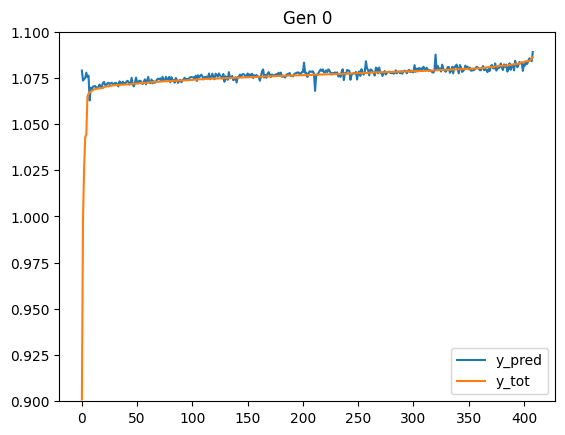

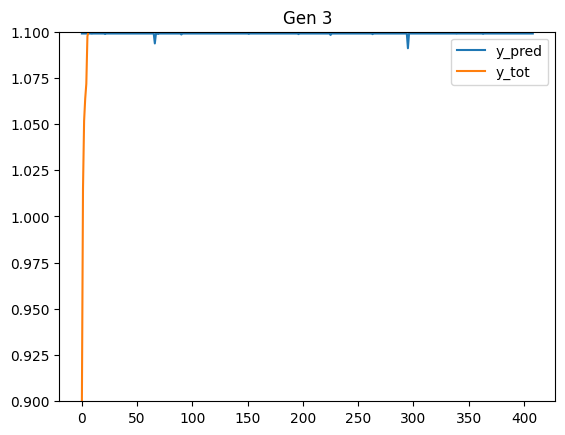

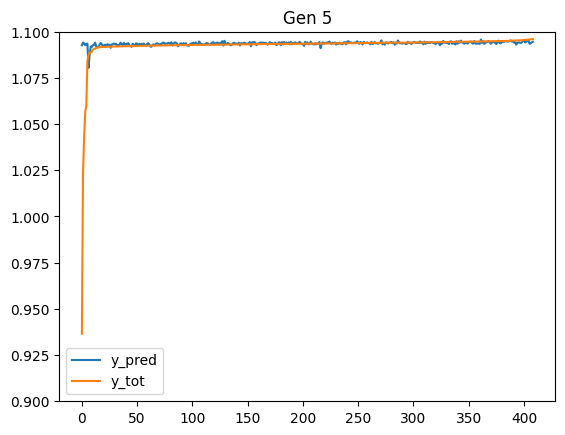

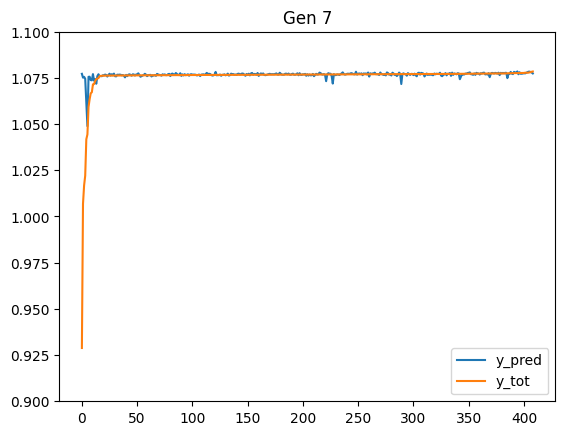

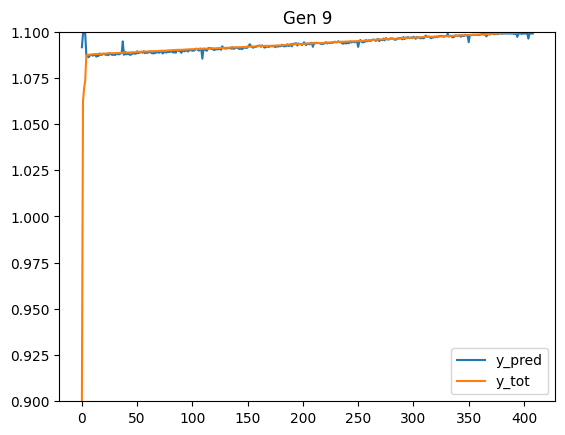

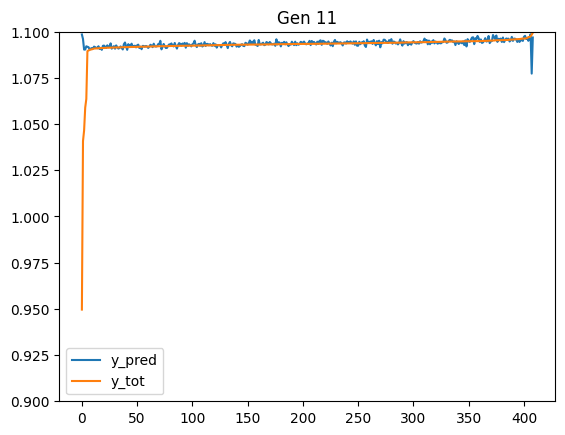

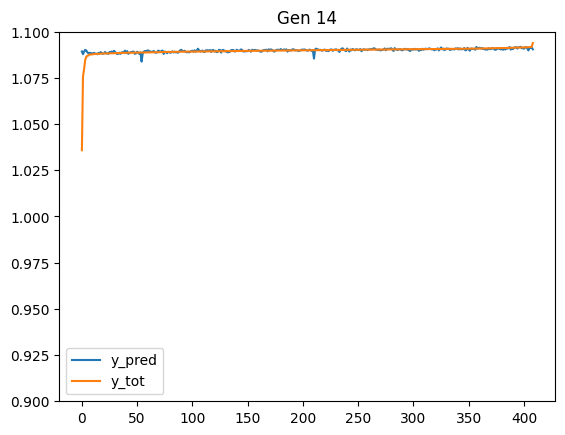

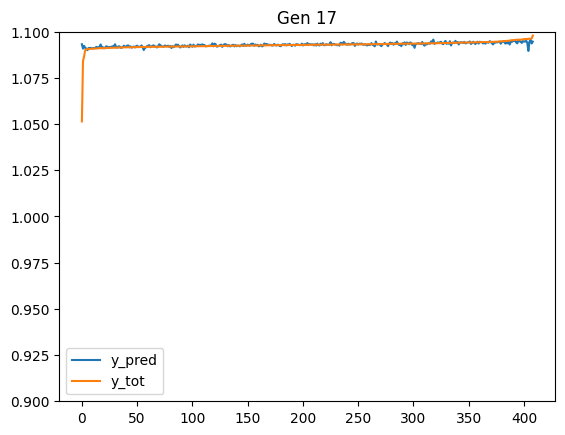

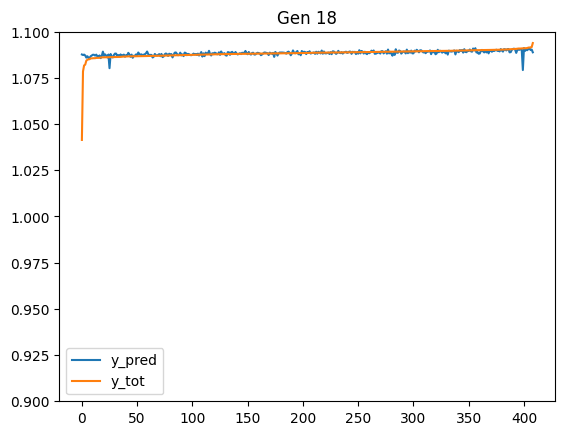

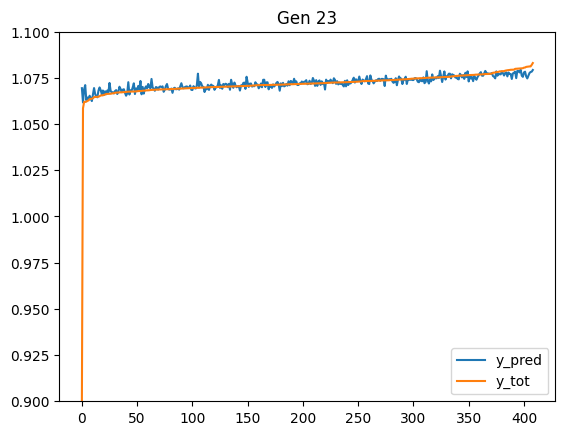

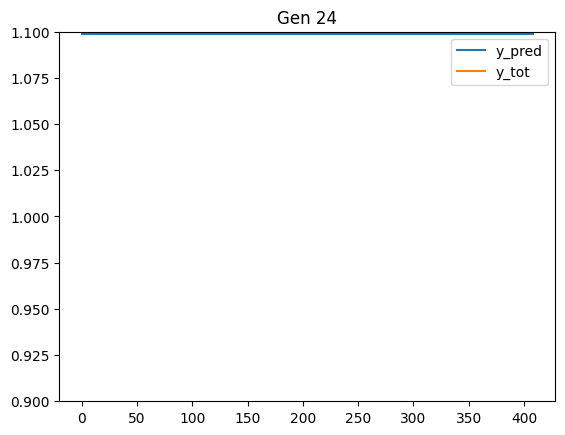

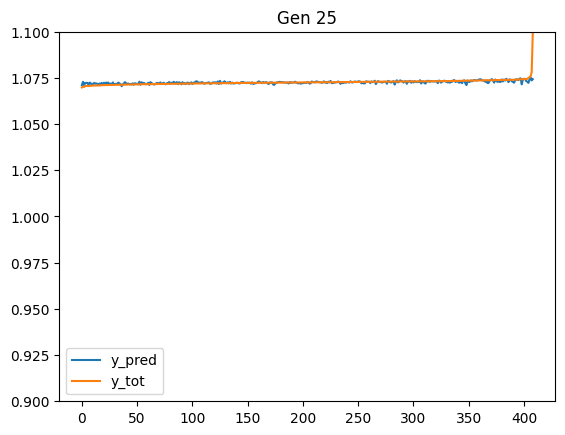

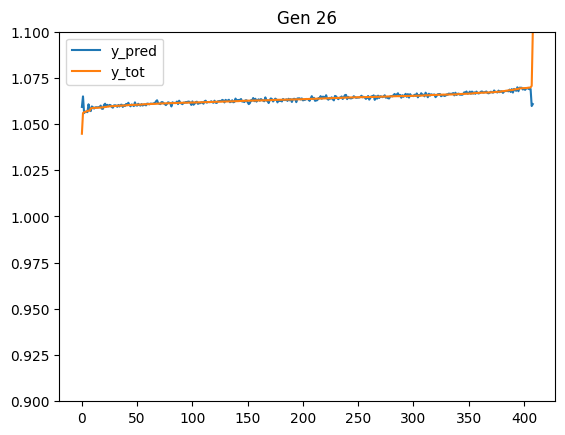

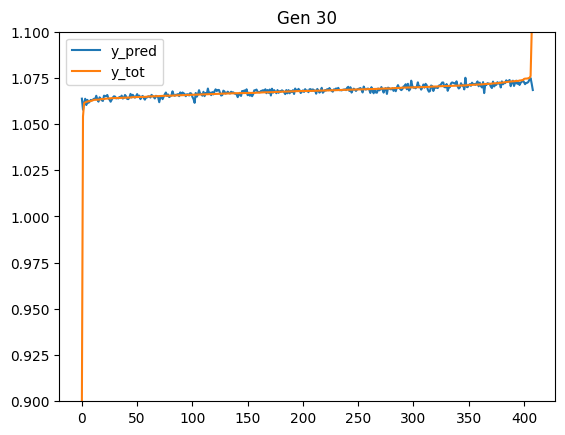

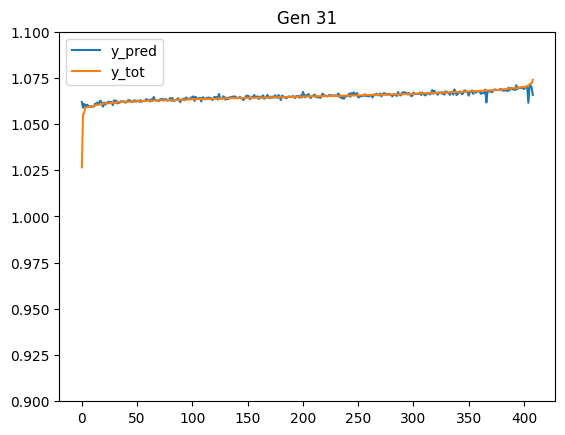

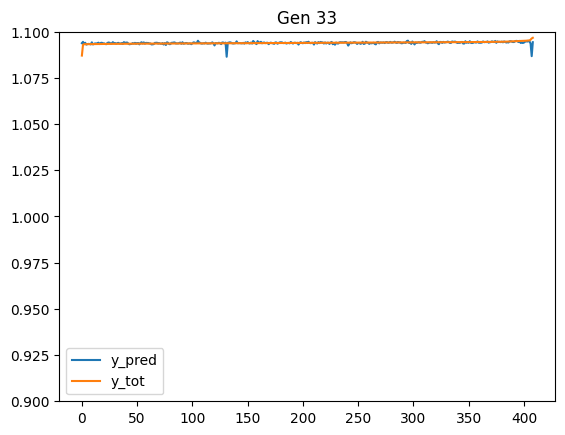

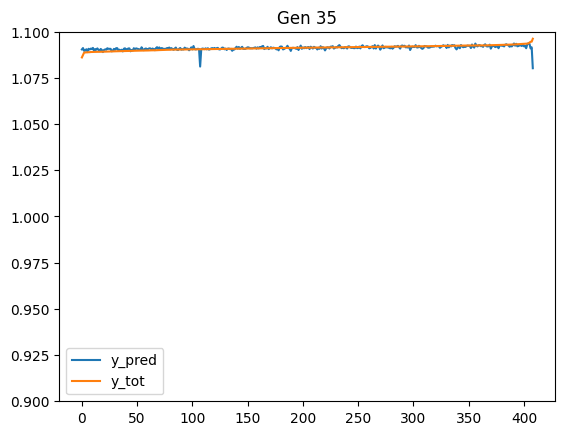

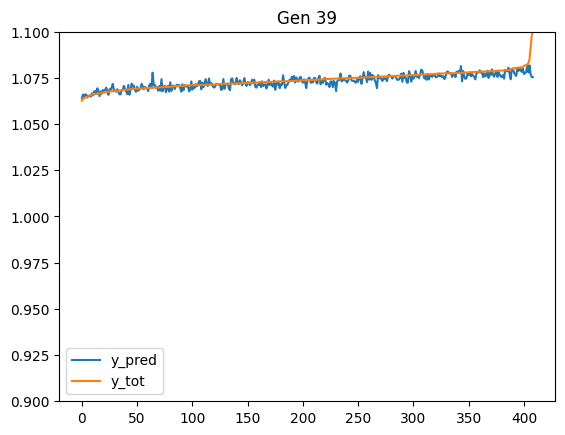

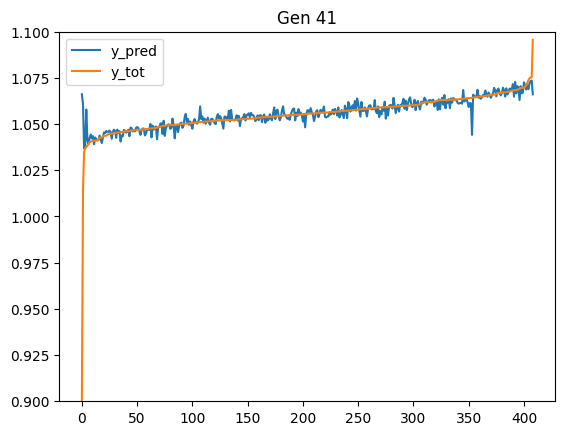

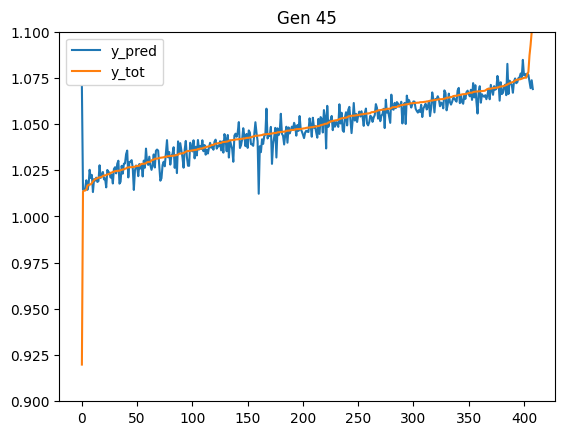

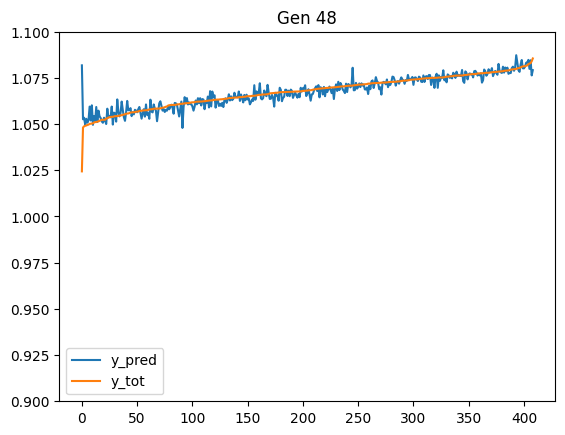

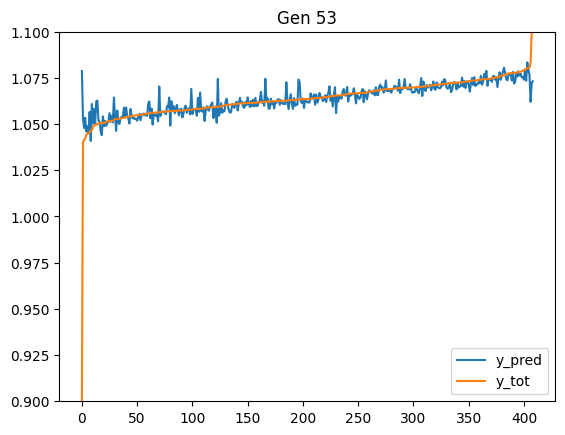

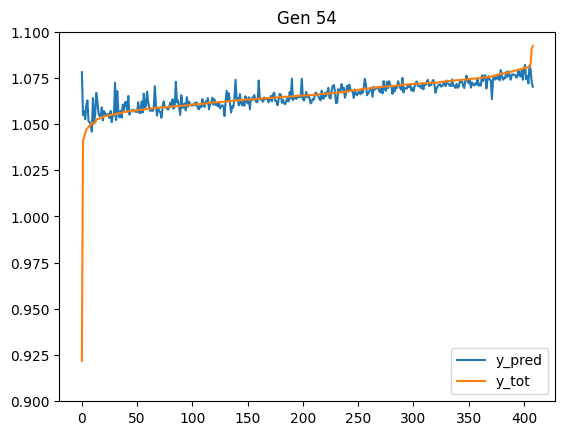

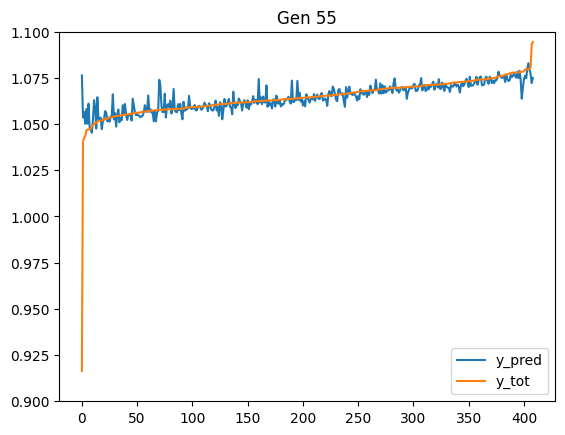

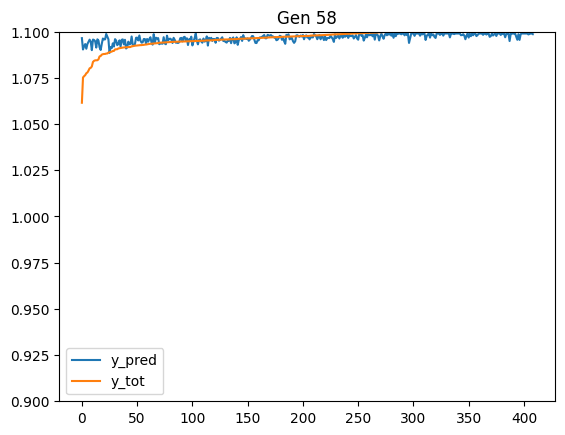

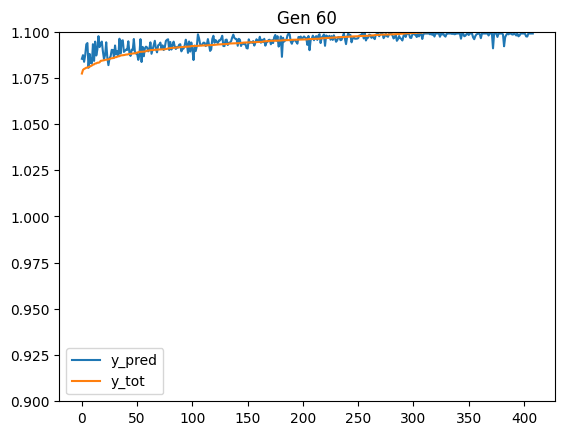

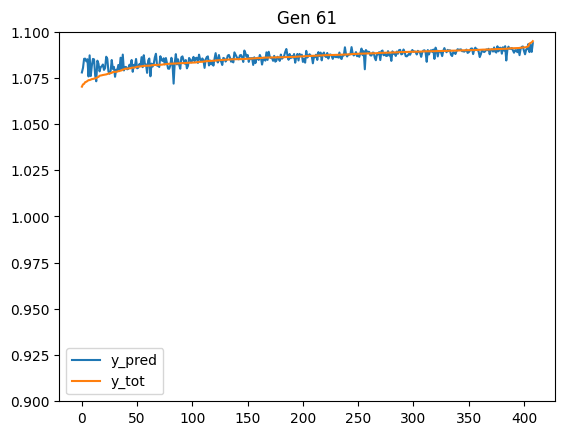

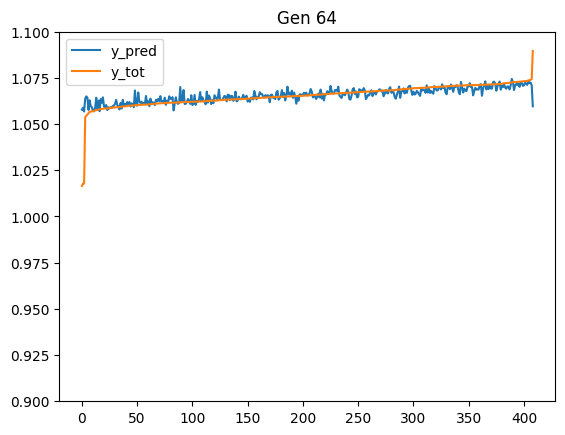

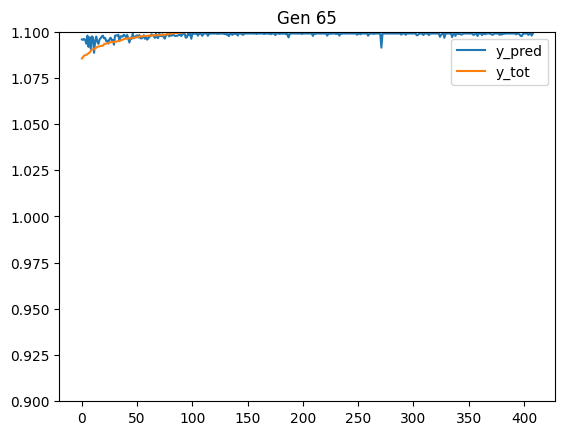

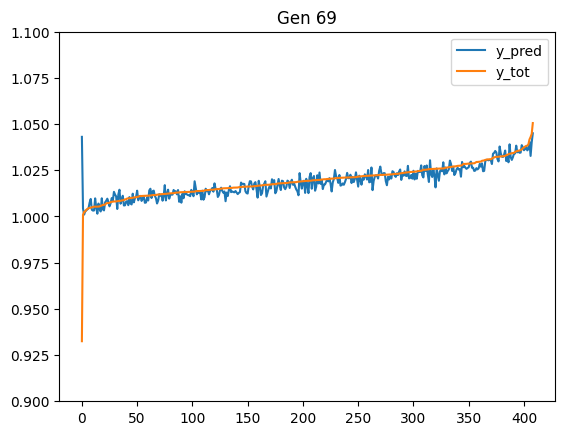

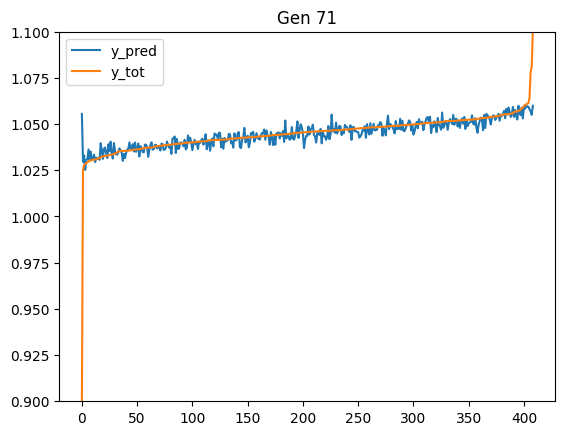

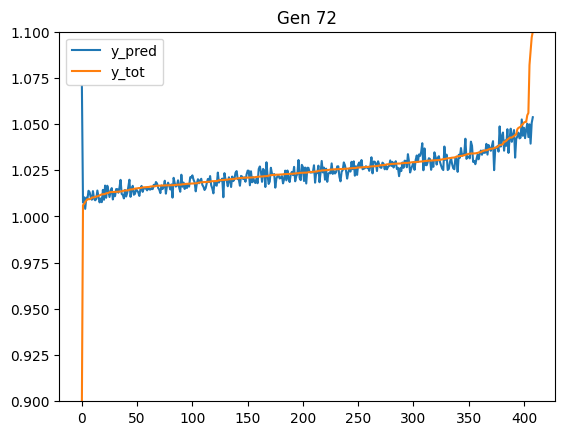

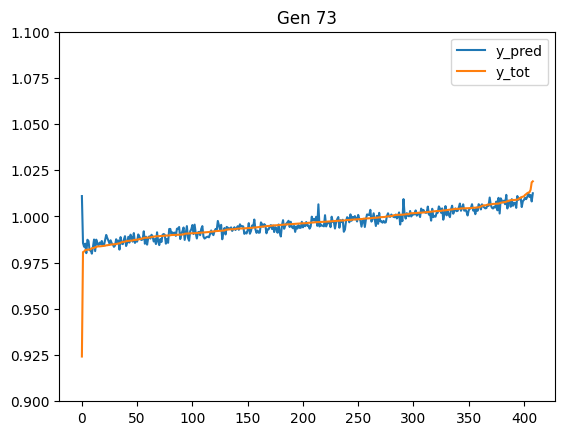

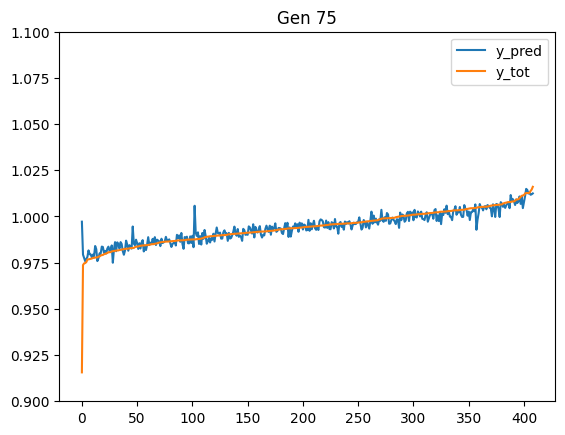

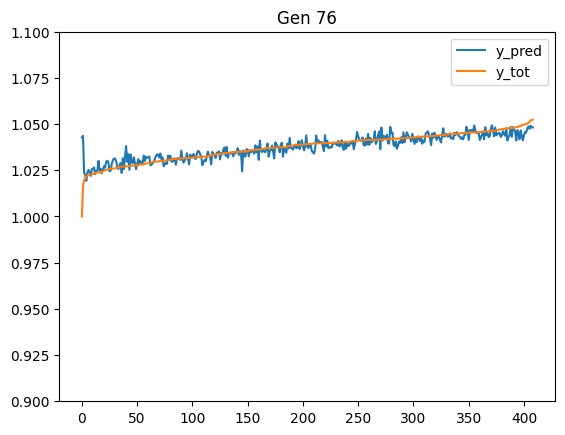

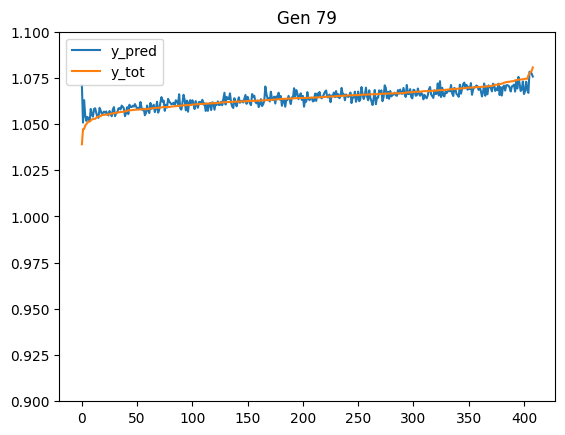

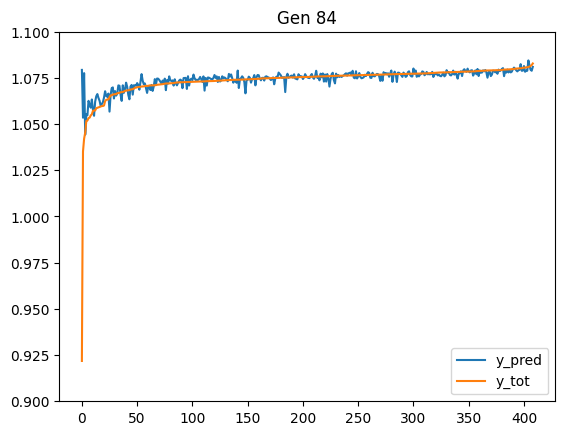

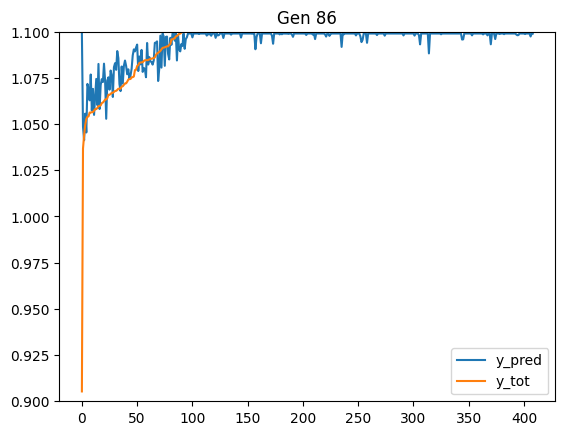

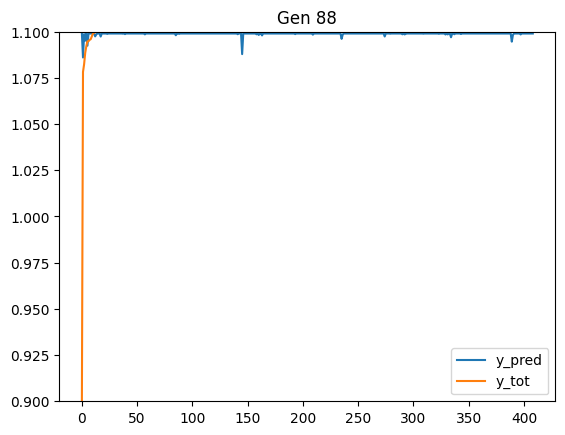

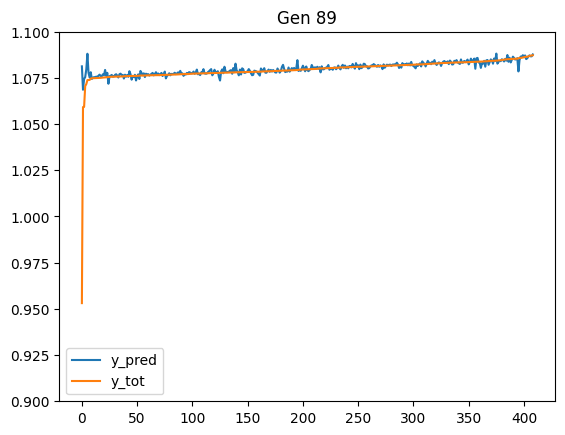

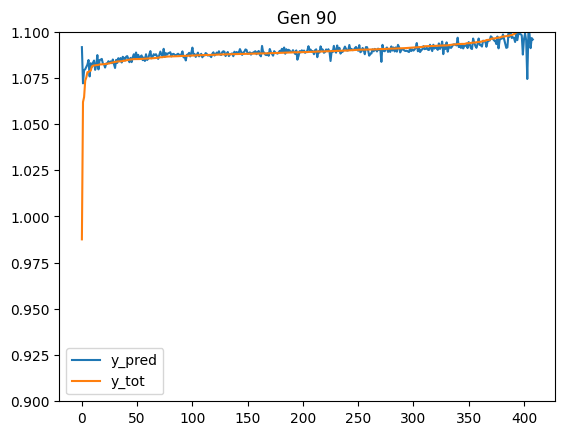

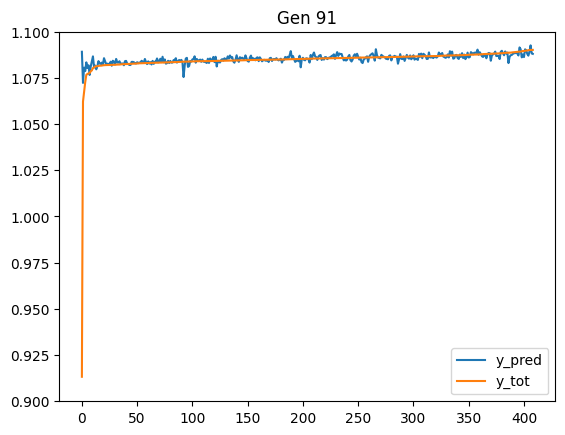

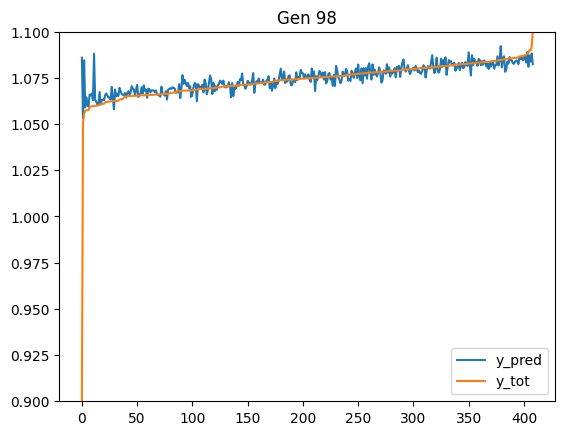

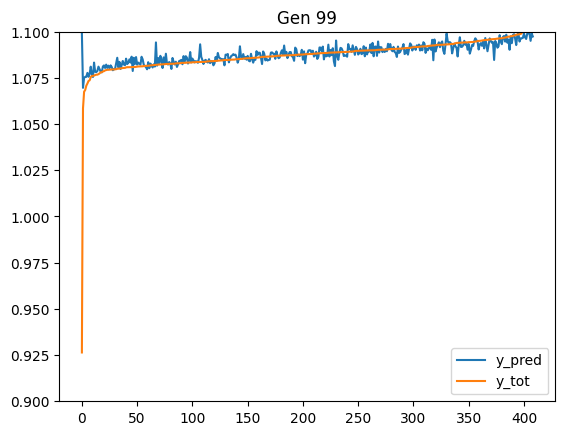

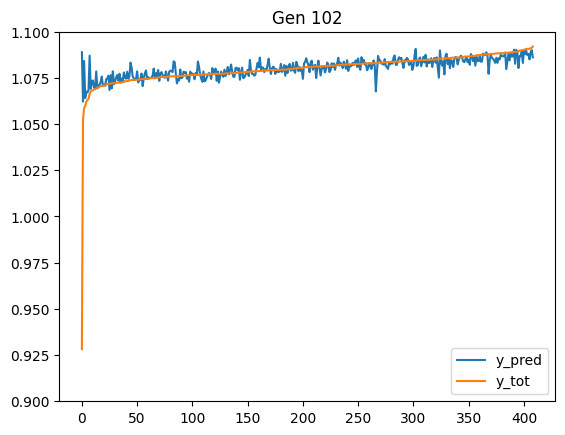

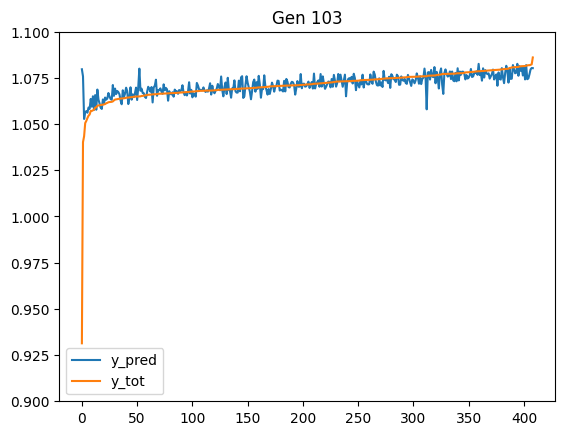

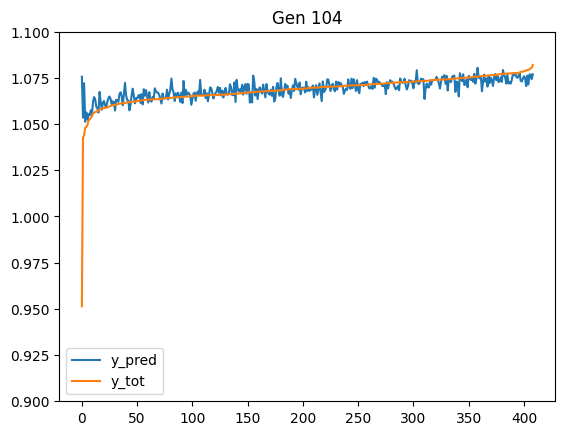

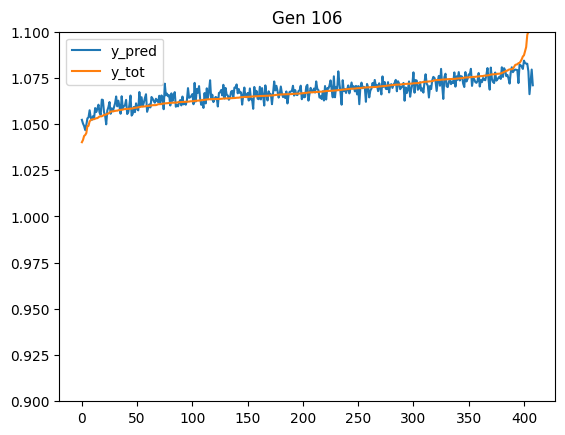

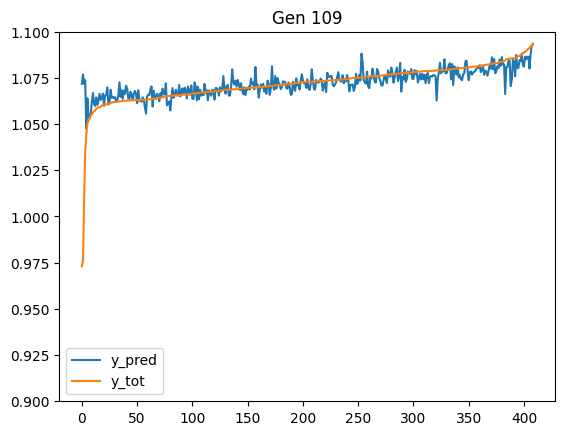

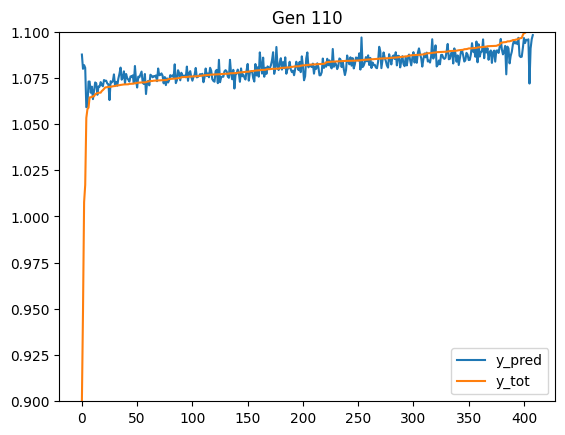

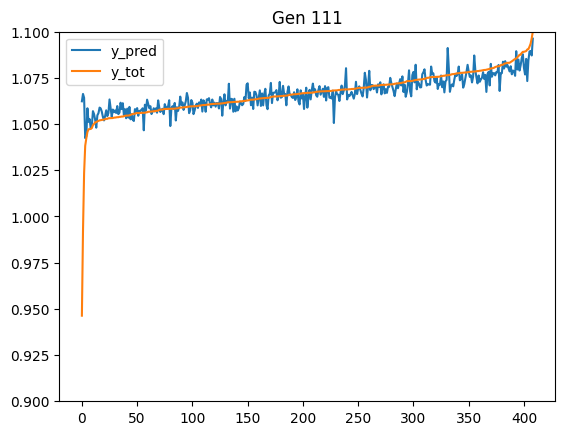

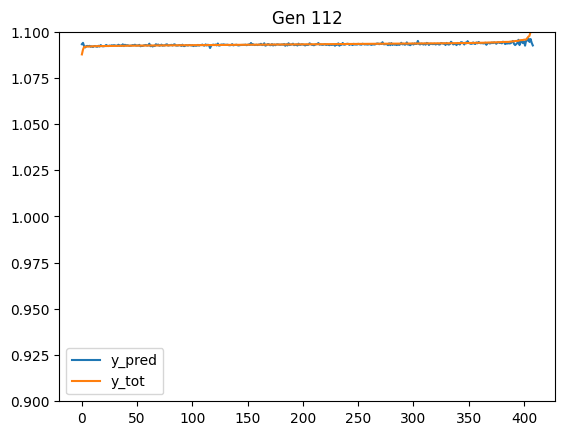

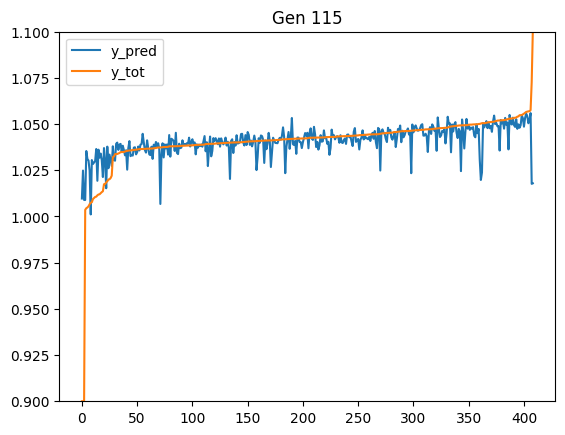

In [42]:
idx_gens = net.gen.bus.values.astype(int)
idx_load = net.load.bus.values.astype(int)
# Plot an histagram per gen of y_pred and y_tot
idx_anomalos = []
idx_promedio = []
for i in idx_gens:
    plt.figure()
    # order y_tot[:,i] from smallest to largest and y_pred[:,i] witj same order
    idx = np.argsort(y_tot[:,i].squeeze())
    y_tot_i = y_tot[idx,i].squeeze()
    y_pred_i = y_pred[idx,i].squeeze()
    idx_anomalos_i = np.hstack([idx[0:5],idx[-5:]])
    idx_anomalos.append(idx_anomalos_i)
    plt.plot(y_pred_i, label='y_pred')
    plt.plot(y_tot_i, label='y_tot')
    # plt.plot([0,1,2,3,4,len(y_pred_i)-5,len(y_pred_i)-4,len(y_pred_i)-3,len(y_pred_i)-2,len(y_pred_i)-1], y_tot[idx_anomalos_i,i].squeeze(), "x")
    plt.title(f"Gen {i}")
    plt.ylim(0.9,1.1)
    plt.legend()
    plt.show()
idx_anomalos = np.array(idx_anomalos).reshape(-1)

## Evaluar desempeño como solucion del ORPD

### Función para evaluar pérdias y unfeasiblity

In [53]:
def get_stats(net,tol=1e-3, percent_gap=None):
    # METRICA
    Y_line_ij = np.asarray(net._ppc["internal"]["Yf"].todense())
    Y_line_ji = np.asarray(net._ppc["internal"]["Yt"].todense())
    V_mag = net.res_bus.vm_pu
    delta = net.res_bus.va_degree
    V = V_mag * np.exp(1j * delta * 2*np.pi/360)
    V_lines_to = [V[x] for x in net.line.to_bus] + [V[x] for x in net.trafo.lv_bus]
    V_lines_from = [V[x] for x in net.line.from_bus] + [V[x] for x in net.trafo.hv_bus]
    ploss = (V_lines_from * np.conj(np.matmul(Y_line_ij,V)) + V_lines_to * np.conj(np.matmul(Y_line_ji,V))).real * net.sn_mva
    ploss_cost = ploss.sum()
    
    # UNFEAS
    
    ## Lineas
    max_line = net.line.max_loading_percent.values.copy()
    if percent_gap is not None:
        max_line = max_line * (1 + percent_gap)
    unfeas_line = (net.res_line.loading_percent.values > max_line + tol).sum()
    gap_line_max = (net.res_line.loading_percent.values - net.line.max_loading_percent.values - tol)/(net.line.max_loading_percent.values - 0)
    gap_line_max = gap_line_max[np.where(gap_line_max > 0)] * 100
    unfeas_trafo = 0
    
    ## Trafos
    gap_trafo_max = []
    if len(net.trafo) > 0:
        max_trafo = net.trafo.max_loading_percent.values.copy()
        if percent_gap is not None:
            max_trafo = max_trafo * (1 + percent_gap)
        unfeas_trafo = (net.res_trafo.loading_percent.values > max_trafo + tol).sum()
        gap_trafo_max = (net.res_trafo.loading_percent.values - net.trafo.max_loading_percent.values - tol)/(net.trafo.max_loading_percent.values - 0)
        gap_trafo_max = gap_trafo_max[np.where(gap_trafo_max > 0)] * 100
    else:
        unfeas_trafo = 0
    
    ## Volts
    max_volt = net.bus.max_vm_pu.values.copy()
    min_volt = net.bus.min_vm_pu.values.copy()
    if percent_gap is not None:
        max_volt +=  percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
        min_volt -= percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    unfeas_volt = (net.res_bus.vm_pu.values < min_volt - tol).sum() + (net.res_bus.vm_pu.values > max_volt + tol).sum()
    gap_volt_max = (net.res_bus.vm_pu.values - net.bus.max_vm_pu.values - tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_max = gap_volt_max[np.where(gap_volt_max > 0)] * 100
    gap_volt_min = (-net.res_bus.vm_pu.values + net.bus.min_vm_pu.values + tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_min = gap_volt_min[np.where(gap_volt_min > 0)] * 100
    
    ## Q ext grid
    max_q_extgrid = net.ext_grid.max_q_mvar.values.astype(float).copy()
    min_q_extgrid = net.ext_grid.min_q_mvar.values.astype(float).copy()
    if percent_gap is not None:
        max_q_extgrid +=  percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
        min_q_extgrid -= percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    unfeas_q_ext_grid = (net.res_ext_grid.q_mvar.values < min_q_extgrid - tol).sum() + (net.res_ext_grid.q_mvar.values > max_q_extgrid + tol).sum()
    gap_q_ext_grid_max = (net.res_ext_grid.q_mvar.values - net.ext_grid.max_q_mvar.values - tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_max = gap_q_ext_grid_max[np.where(gap_q_ext_grid_max > 0)] * 100
    gap_q_ext_grid_min = (-net.res_ext_grid.q_mvar.values + net.ext_grid.min_q_mvar.values + tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_min = gap_q_ext_grid_min[np.where(gap_q_ext_grid_min > 0)] * 100

    # Juntar todo
    gaps_percentages = []
    if len(gap_line_max) > 0:
        gaps_percentages += list(gap_line_max)
    if len(gap_trafo_max) > 0:
        gaps_percentages += list(gap_trafo_max)
    if len(gap_volt_max) > 0:
        gaps_percentages += list(gap_volt_max)
    if len(gap_volt_min) > 0:
        gaps_percentages += list(gap_volt_min)
    if len(gap_q_ext_grid_max) > 0:
        gaps_percentages += list(gap_q_ext_grid_max)
    if len(gap_q_ext_grid_min) > 0:
        gaps_percentages += list(gap_q_ext_grid_min)
        
    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0 or unfeas_q_ext_grid > 0:
        unfeas = True
    else:
        unfeas = False
    return ploss_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt, unfeas_q_ext_grid], gaps_percentages



### Ejecutar la función para datos de test

In [54]:

v_cost_hist = []
unf_hist = []
unf_cont_hist = []
gap_percentages_hist_pred = []
gap_percentages_hist_opt = []
gap_percentages_hist_v1 = []

percent_gap = 0.0 # CAMBIAR POR TOLERANCIA DESEADA EN PORCENTAJE DIVIDIO 100 (0.036 IEEE30, 0.010 IEEE118)

for idx in range(np.shape(x_tot)[0]):
    
    # Cargar entradas
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]
    
    # Cargar solucion predecida
    net.gen.vm_pu = y_pred[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_pred, unf_pred, unf_const_pred, gaps_percentages_pred = get_stats(net,percent_gap=percent_gap)

    # Cargar solucion naive
    net.gen.vm_pu = 1
    pp.runpp(net, enforce_q_lims=True)
    v_cost_v1, unf_v1, unf_const_v1, gaps_percentages_v1  = get_stats(net,percent_gap=percent_gap)
    
    # Cargar solución óptima
    net.gen.vm_pu = y_tot[idx,idx_gens,0]
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt, gaps_percentages_opt  = get_stats(net,percent_gap=percent_gap)
    
    # Guardar resultados para la iteracion
    v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
    unf_hist.append([unf_pred, unf_opt, unf_v1])
    unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])
    gap_percentages_hist_pred += gaps_percentages_pred
    gap_percentages_hist_opt += gaps_percentages_opt
    gap_percentages_hist_v1 += gaps_percentages_v1


v_cost_hist = np.array(v_cost_hist)
unf_hist = np.array(unf_hist)
unf_cont_hist = np.array(unf_cont_hist)


### Observar resultados

In [57]:
print(f"El porcentaje de factibles para el óptimo es: {1 - unf_hist[:,1].mean(axis=0)}")
print(f"El porcentaje de factibles para la predicción es: {1 - unf_hist[:,0].mean(axis=0)}")
print(f"El porcentaje de factibles para el naive es: {1 - unf_hist[:,2].mean(axis=0)}")

El porcentaje de factibles para el óptimo es: 0.9095354523227384
El porcentaje de factibles para la predicción es: 0.9511002444987775
El porcentaje de factibles para el naive es: 0.9633251833740831


In [58]:
print(f"El costo promedio para el óptimo es: {v_cost_hist[:,1].mean(axis=0)}")	
print(f"El costo promedio para la predicción es: {v_cost_hist[:,0].mean(axis=0)}")
print(f"El costo promedio para el naive es: {v_cost_hist[:,2].mean(axis=0)}")


El costo promedio para el óptimo es: 84.93519191180387
El costo promedio para la predicción es: 84.55683096619278
El costo promedio para el naive es: 96.09988784634913


In [66]:
if arq == 'FCNN_global':
    v_cost_hist_FCNN = v_cost_hist.copy()
    unf_hist_FCNN = unf_hist[:,0].copy()
else:
    v_cost_hist_GNN = v_cost_hist.copy()
    unf_hist_GNN = unf_hist[:,0].copy()


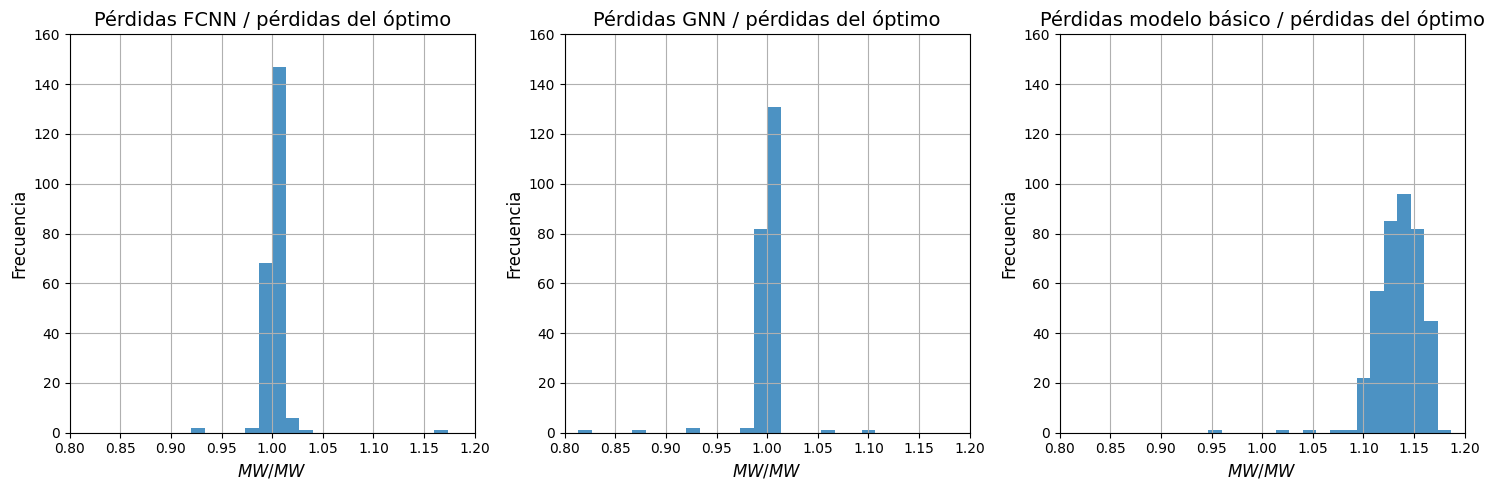

In [67]:
# 3 subplots with histograms
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].hist(v_cost_hist_FCNN[unf_hist_FCNN == 0,0] / v_cost_hist_FCNN[unf_hist_FCNN == 0,1], bins=30, range=(0.8, 1.2),alpha=0.8, label='FCNN/opt')
axs[0].set_title("Pérdidas FCNN / pérdidas del óptimo",fontsize=14)
axs[0].grid()
axs[0].set_xlabel(r'$MW/MW$',fontsize=12)
axs[0].set_ylabel("Frecuencia",fontsize=12)
axs[0].set_xlim([0.8, 1.2])
axs[0].set_ylim([0, 160])
axs[1].hist(v_cost_hist_GNN[unf_hist_GNN == 0,0] / v_cost_hist_GNN[unf_hist_GNN == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, label='GNN/opt')
axs[1].set_title("Pérdidas GNN / pérdidas del óptimo",fontsize=14)
axs[1].grid()
axs[1].set_xlabel(r'$MW/MW$',fontsize=12)
axs[1].set_ylabel("Frecuencia",fontsize=12)
axs[1].set_xlim([0.8, 1.2])
axs[1].set_ylim([0, 160])
axs[2].hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, label='v1/opt')
axs[2].set_title("Pérdidas modelo básico / pérdidas del óptimo",fontsize=14)
axs[2].grid()
axs[2].set_xlabel(r'$MW/MW$',fontsize=12)
axs[2].set_ylabel("Frecuencia",fontsize=12)
axs[2].set_xlim([0.8, 1.2])
axs[2].set_ylim([0, 160])

plt.tight_layout()
plt.show()

fig.savefig(f"/home/nacho/sup_ieee/resultados/figs/histograma_comparacion_costos_{red}.pdf")

El porcentaje de unfeasibles en el predecido es 0.012048192771084338, un total de 4
El porcentaje de unfeasibles en el optimo es 0.0, un total de 0
El porcentaje de unfeasibles en el setpoint 1 es 0.19879518072289157, un total de 66


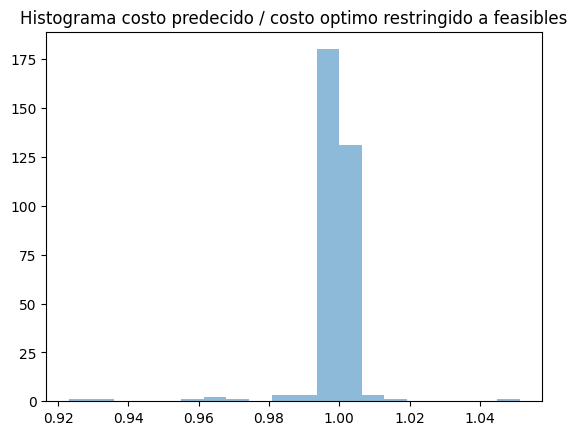

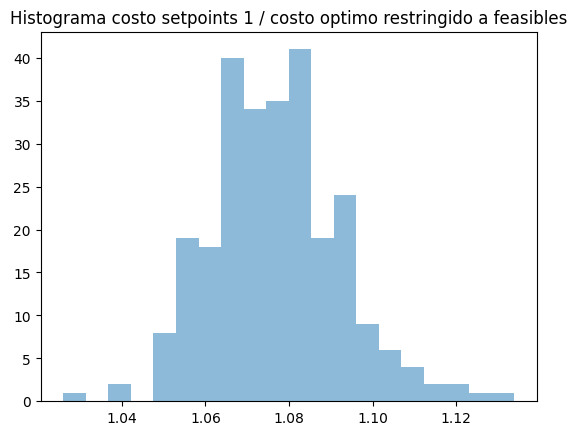

In [25]:
# FEASIBILITY

print(f"El porcentaje de unfeasibles en el predecido es {np.mean(unf_hist[:,0], axis=0)}, un total de {np.sum(unf_hist[:,0], axis=0)}")
print(f"El porcentaje de unfeasibles en el optimo es {np.mean(unf_hist[:,1], axis=0)}, un total de {np.sum(unf_hist[:,1], axis=0)}")
print(f"El porcentaje de unfeasibles en el setpoint 1 es {np.mean(unf_hist[:,2], axis=0)}, un total de {np.sum(unf_hist[:,2], axis=0)}")

# Quedarme con los v_cost de los feasible

plt.title("Histograma costo predecido / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,0] == 0,0] / v_cost_hist[unf_hist[:,0] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()


plt.title("Histograma costo setpoints 1 / costo optimo restringido a feasibles")
plt.hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=20, alpha=0.5, label='pred/v1')
plt.show()

In [68]:
if arq == 'FCNN_global':
    gap_percentages_hist_FCNN = gap_percentages_hist_pred.copy()
else:
    gap_percentages_hist_GNN = gap_percentages_hist_pred.copy()
    


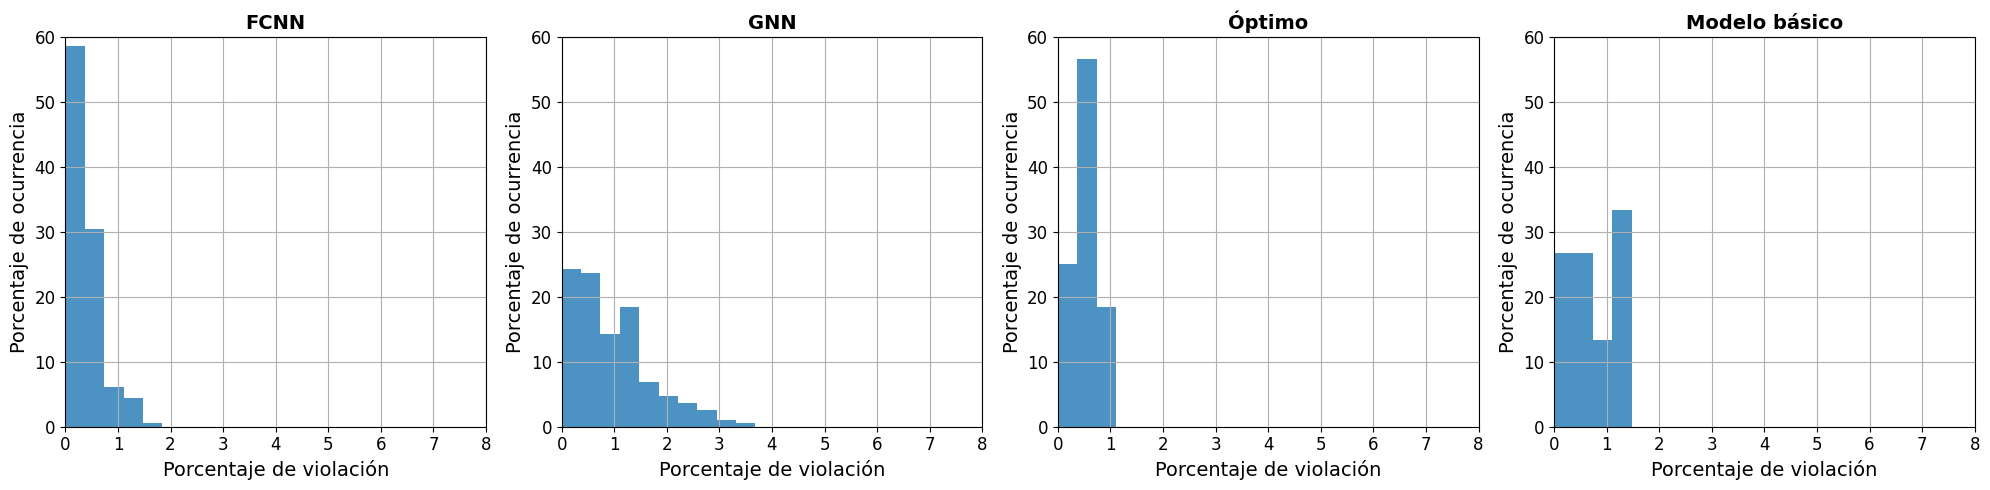

In [72]:
import matplotlib.pyplot as plt
# # Plot the normalized histogram for pred
# plt.title("Histograma de gaps en porcentaje para pred")
# plt.hist(gap_percentages_hist_pred, bins=10, alpha=0.5, density=True)  # Normalize the histogram
# plt.show()

# # Plot the normalized histogram for opt
# plt.title("Histograma de gaps en porcentaje para opt")
# plt.hist(gap_percentages_hist_opt, bins=10, alpha=0.5, density=True)  # Normalize the histogram
# plt.show()

bins = np.linspace(0, 7, 20)  # Creates 10 bins from 0 to 10

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Define consistent limits for the x and y axes
# x_limits = (0, 6.5)
# y_limits = (0, 36) 
x_limits = (0, 8)
y_limits = (0, 60)

# Plot the normalized histogram for pred FCNN
axs[0].set_title("FCNN", fontsize=14, fontweight='bold')
axs[0].hist(gap_percentages_hist_FCNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_FCNN) / len(gap_percentages_hist_FCNN) * 100)  
axs[0].set_xlabel("Porcentaje de violación", fontsize=14)
axs[0].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid()

# Plot the normalized histogram for pred GNN
axs[1].set_title("GNN", fontsize=14, fontweight='bold')
axs[1].hist(gap_percentages_hist_GNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_GNN) / len(gap_percentages_hist_GNN) * 100) 
axs[1].set_xlabel("Porcentaje de violación", fontsize=14)
axs[1].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid()

# Plot the normalized histogram for opt
axs[2].set_title("Óptimo", fontsize=14, fontweight='bold')
axs[2].hist(gap_percentages_hist_opt, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_opt) / len(gap_percentages_hist_opt) * 100)  
axs[2].set_xlabel("Porcentaje de violación", fontsize=14)
axs[2].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
axs[2].tick_params(axis='both', which='major', labelsize=12)
axs[2].grid()

# Plot the normalized histogram for v1
axs[3].set_title("Modelo básico", fontsize=14, fontweight='bold')
axs[3].hist(gap_percentages_hist_v1, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_v1) / len(gap_percentages_hist_v1) * 100)  
axs[3].set_xlabel("Porcentaje de violación", fontsize=14)
axs[3].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[3].set_xlim(x_limits)
axs[3].set_ylim(y_limits)
axs[3].tick_params(axis='both', which='major', labelsize=12)
axs[3].grid()

plt.tight_layout()
plt.show()
fig.savefig(f"/home/nacho/sup_ieee/resultados/figs/gaps_{red}.pdf")

## Analiza Tiempo

In [30]:
import time 

ts = []
for x,y in test_loader:
    for dato in x:
        t_0 = time.time()
        _ = model(dato.unsqueeze(0), training=False, denormalize_y=cfg.data.normalize_Y).detach().cpu().numpy()
        t_f = time.time()
        ts.append(t_f-t_0)

print(f"El tiempo por dato promedio para {arq}/IEEE{red} es {np.mean(ts)}")


El tiempo por dato promedio para FCNN_global/IEEE30 es 0.0002821445465087891


In [31]:
import time 

ts = []
t_0 = time.time()
for x,y in test_loader:
        _ = model(x, training=False, denormalize_y=cfg.data.normalize_Y).detach().cpu().numpy()
t_f = time.time()

print(f"El tiempo para todo el conjunto de test es de {t_f-t_0}")

El tiempo para todo el conjunto de test es de 0.007463693618774414


In [77]:
import time 
ts = []
net.line["pm_param/target_branch"] = True
pp.runpm_ploss(net)
for idx in range(np.shape(x_tot)[0]):
    t_0 = time.time()
    net.load.loc[:,'p_mw'] = x_tot[idx,idx_load,0]
    net.load.loc[:,'q_mvar'] = x_tot[idx,idx_load,1]
    net.gen.loc[:,'p_mw'] =  x_tot[idx,idx_gens,2]
    pp.runpm_ploss(net)
    t_f = time.time()
    ts.append(t_f-t_0)
    
print(f"El tiempo para el IPOPT para cada dato es {np.mean(ts)}")
print(f"El tiempo para el IPOPT para el conjunto de test es {np.sum(ts)}")